Shape of dataset: (100000, 9)
Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
Missing values per column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
After balancing:
Training data size: (145750, 8)
Class distribution:
 1    72875
0    72875
Name: diabetes, dtype: int64
SVM training on sample size: 14575

=== Training SVM ===
SVM training completed.

=== Training Neural Network ===
Neural Network training completed.

=== Training XGBoost ===
XGBoost training completed.

=== Training Hybrid Ensemble Model ===
Hybrid ensemble training completed.

=== Evaluating Manual Hybrid Ensemble ===
Hybrid Ensemble Accuracy: 92.4%
Classification Report:
               precision    recall  f1-score   support

           0  

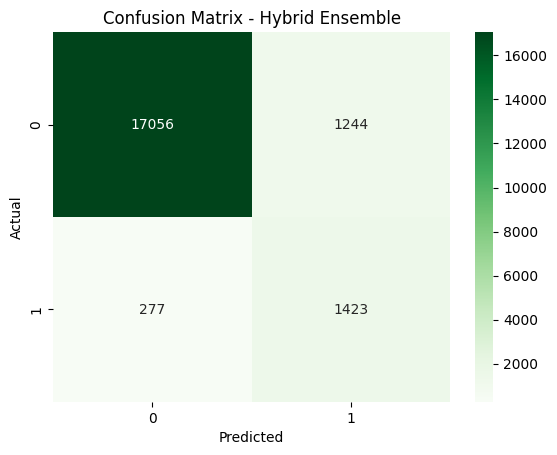

--- Starting File Re-Save ---
Saved: scaler.pkl
Saved: svm_model.pkl
Saved: xgb_model.pkl
Saved: nn_model.pkl (MLPClassifier)
--- Re-Save Complete ---

🎉 Hybrid Ensemble Model Saved Successfully!
Saved as: scaler.pkl , svm_model.pkl , xgb_model.pkl , nn_model.pkl


In [ ]:
# =====================================================
# 🔥 ENHANCED HYBRID DIABETES PREDICTION PIPELINE
# Includes Feature Importance + Dynamic User Input
# =====================================================

# -----------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import joblib # type: ignore # Added import for joblib
from scipy.stats import mode

# -----------------------------------------
# 2️⃣ Load Dataset
# -----------------------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes_prediction_dataset.csv")

print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

# -----------------------------------------
# 3️⃣ Encode Categorical Columns
# -----------------------------------------
cat_cols = ['gender', 'smoking_history']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# -----------------------------------------
# 4️⃣ Define Features & Target
# -----------------------------------------
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# -----------------------------------------
# 5️⃣ Split into Train-Test
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------
# 6️⃣ Handle Class Imbalance (SMOTETomek)
# -----------------------------------------
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

print("After balancing:")
print("Training data size:", X_res.shape)
print("Class distribution:\n", y_res.value_counts())

# -----------------------------------------
# 7️⃣ Scale Numeric Columns
# -----------------------------------------
scaler = RobustScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------
# 8️⃣ Prepare SVM training sample (10% for speed)
# -----------------------------------------
X_svm_train, _, y_svm_train, _ = train_test_split(
    X_res_scaled, y_res, train_size=0.1, stratify=y_res, random_state=42
)

print(f"SVM training on sample size: {X_svm_train.shape[0]}")

# -----------------------------------------
# 9️⃣ Define Individual Models
# -----------------------------------------
models = {
    "SVM": SVC(probability=False, kernel='rbf', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

# -----------------------------------------
# 🔟 Train Individual Models
# -----------------------------------------
results = {}

# Train SVM on sample only
print("\n=== Training SVM ===")
models["SVM"].fit(X_svm_train, y_svm_train)
print("SVM training completed.")

# Train others on full balanced set
print("\n=== Training Neural Network ===")
models["Neural Network"].fit(X_res_scaled, y_res)
print("Neural Network training completed.")

print("\n=== Training XGBoost ===")
models["XGBoost"].fit(X_res_scaled, y_res)
print("XGBoost training completed.")

# -----------------------------------------
# 1️⃣1️⃣ Evaluate Individual Models is removed
# -----------------------------------------

# -----------------------------------------
# 1️⃣2️⃣ Create and Train Hybrid Ensemble (hard voting)
# -----------------------------------------
ensemble = VotingClassifier(
    estimators=[('svm', models['SVM']),
                ('nn', models['Neural Network']),
                ('xgb', models['XGBoost'])],
    voting='hard'  # use hard voting since svm has no predict_proba
)

print("\n=== Training Hybrid Ensemble Model ===")
def manual_ensemble_predict(X):
    preds = []
    preds.append(models['SVM'].predict(X))
    preds.append(models['Neural Network'].predict(X))
    preds.append(models['XGBoost'].predict(X))

    preds = np.array(preds)  # shape (3, n_samples)

    from scipy.stats import mode
    majority_preds, _ = mode(preds, axis=0)
    return majority_preds.flatten()

print("Hybrid ensemble training completed.")
# -----------------------------------------
# 1️⃣3️⃣ Evaluate Hybrid Ensemble
# -----------------------------------------

print("\n=== Evaluating Manual Hybrid Ensemble ===")
y_pred_ensemble = manual_ensemble_predict(X_test_scaled)

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)

print(f"Hybrid Ensemble Accuracy: {round(acc_ensemble*100, 2)}%")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Hybrid Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

results['Hybrid Ensemble'] = {"Accuracy": acc_ensemble}

# -----------------------------------------
# ✅ Convert Manual Ensemble into Saveable Model
# -----------------------------------------
class HybridEnsembleModel:
    def __init__(self, svm, nn, xgb):
        self.svm = svm
        self.nn = nn
        self.xgb = xgb

    def predict(self, X):
        svm_pred = self.svm.predict(X)
        nn_pred = self.nn.predict(X)
        xgb_pred = self.xgb.predict(X)

        stacked = np.vstack([svm_pred, nn_pred, xgb_pred])
        majority_vote, _ = mode(stacked, axis=0)
        return majority_vote.flatten()

# Create hybrid model instance
hybrid_model = HybridEnsembleModel(
    svm=models["SVM"],
    nn=models["Neural Network"],
    xgb=models["XGBoost"]
)


# Assuming 'scaler' and 'models' (containing 'SVM', 'XGBoost', 'Neural Network') are available here

print("--- Starting File Re-Save ---")

# 1. Save the Scaler
joblib.dump(scaler, "scaler.pkl")
print("Saved: scaler.pkl")

# 2. Save the SVM model
joblib.dump(models['SVM'], "svm_model.pkl")
print("Saved: svm_model.pkl")

# 3. Save the XGBoost model
joblib.dump(models['XGBoost'], "xgb_model.pkl")
print("Saved: xgb_model.pkl")

# 4. Save the Neural Network (MLPClassifier) model
joblib.dump(models['Neural Network'], "nn_model.pkl")
print("Saved: nn_model.pkl (MLPClassifier)")

print("--- Re-Save Complete ---")

print("\n🎉 Hybrid Ensemble Model Saved Successfully!")
print("Saved as: scaler.pkl , svm_model.pkl , xgb_model.pkl , nn_model.pkl")
